# Embarrassingly Parallel

Julia is built to run fast. It has parallel paradigms built in its core. Let's have a look at the simplest one to use: embarrassingly parallel. 

First we prepare the environment by making all the exported symbols, types and functions defined in two modules, `BenchmarkTools` and `Distributed` searchable. For example the function `addprocs` is defined in `Distributed` and it can be called directly from the REPL once `using Distributed` is executed.

`addprocs(4)` adds four worker processes and the macro `@everywhere`, again defined in `Distributed`, executes `using LinearAlgebra` in all these four processes so that all the names exported from `LinearAlgebra` are made available to all the worker processes.

In [1]:
using BenchmarkTools,Distributed,VegaLite,Colors
addprocs(4);
@everywhere using LinearAlgebra

## pmap

Let's try out the first Julia function that launches an embarrassingly parallel task in a single line.

`pmap` transforms collections such as vectors like `Float64[1,2,3]` and unit ranges like `1:10` by applying a function to all their elements using available workers and tasks.

It assumes the function has been made available to all workers and in the following example, `@everywhere` execute the function definition on all the four workers before calling it from the `pmap` function.

In [2]:
@everywhere f(x) = x^2+2x+1
pp = pmap(f,1:10^3);
@show pp[1:10];

pp[1:10] = [4, 9, 16, 25, 36, 49, 64, 81, 100, 121]


It is also possible to pass it as an anonymous function without using `@everywhere`.

In [3]:
rr = pmap(x->x^2+2x+1,1:10^3);
@show rr[1:10];

rr[1:10] = [4, 9, 16, 25, 36, 49, 64, 81, 100, 121]


Unfortunately, in the above two examples, if any error occurs on any worker, the entire `pmap` task stops. Try `pmap(x->log10(x),rand(-10:10,3))` and see what happens.

`pmap` handles the possible exceptions gracefully by taking an argument called `on_error`. It allows to pass exceptions to the result collection so that the parallel task continues or to rethrow the error to the caller.  

In [4]:
pmap(x->(x,log10(x)),rand(-10:10,3),on_error=identity)
pmap(x->(x,log10(x)),rand(-10:10,3),on_error=e->e)
pmap(x->(x,log10(x)),rand(-10:10,3),on_error=e->isa(e,DomainError) ? (e.val,nothing) : rethrow() )

3-element Vector{Tuple{Real, Any}}:
 (-3.0, nothing)
 (4, 0.6020599913279624)
 (-5.0, nothing)

To handle errors that may be fixed by retires,for example HTTP connection timeout,  `pmap` allows specific definition of the retry behavior such as the number of retries and seconds between retries. In the following example, there is a small chance, ~9%, that in at least one of the worker processes `log10` receives the input of `-1` and runs into DomainError which stops the entire `pmap` task. By allowing three retries, it reduces that chance of failure to ~ 7.5$\unicode{x2031}$.

In [5]:
pmap(x->(x,log10(x)),rand(-1:30,3),retry_delays = ExponentialBackOff(n = 3))

3-element Vector{Tuple{Int64, Float64}}:
 (13, 1.1139433523068367)
 (9, 0.9542425094393249)
 (14, 1.146128035678238)

### Things to Try

1. Understand the retry behavior defined by `ExponentialBackOff(n = 3)`. 
1. Explore the arguments `batch_size` and `retry_delays`.
1. Try both `on_error` and `retry_delays` in the same pmap call.

## Parallel For Loop @distributed

Another way to launch an embarrassingly parallel task is to wrap it in a parallel for loop using the @distributed macro.

To run the same task as shown in the first two `pmap` examples, simply add the macro `@distributed` with a reducer function in front of the for loop like the following.

In [6]:
qq = @distributed (append!) for x in 1:10^3
    [x^2+2x+1]
end;
@show qq[1:10];

qq[1:10] = [4, 9, 16, 25, 36, 49, 64, 81, 100, 121]


### Reducers
The reducer used in the above parallel loop example is `append!` which collects all the return values into a single vector, other popular ones are `+` and `vcat`. One can even define their own reducer functions. The reducer functions must satisfy the following two conditions:

1. it can take two input arguments
1. its input and return type are identical


In [7]:
@everywhere f(a,b)=[a...;b]
xx = @distributed (f) for x in 1:10
    x^2+2x+1
end;

yy = @distributed ((a,b)->[a...;b]) for x in 1:10
    x^2+2x+1
end;

@show xx, yy;

(xx, yy) = ([4, 9, 16, 25, 36, 49, 64, 81, 100, 121], [4, 9, 16, 25, 36, 49, 64, 81, 100, 121])


### Things to Try

1. Use the reducer function g(a,b)=(a,b,"tag") to understand how the reduction happens across all available workers.
1. Define a reducer function that takes two values from each subtask and return to a tuple whose first element is the sum of all first values and the second element is the multiplication of all the second values.
1. Handle exceptions in the `@distributed` for loop so that it retries when the DomainError occurs.

## Comparison 

Both `pmap` and `@distributed` can be used to launch parallel tasks that require no communications. Sometimes it is more feasible to use one rather than the other.

We have demonstrated that when using `pmap`, the return value has to be an array with the same size/shape of the input value while the parallel for loop allows reductions and therefore the type of the return value can be more flexible.

However, there is more to consider when choosing which one to use. 

### Static Vs Dynamic Scheduling

First of all, the `@distributed` for loop statically schedules its workload while `pmap` uses dynamic scheduling. When the parallel for loop decides which subtask to send to which worker, it divides the total workload into equal partitions and dispatches each partition to one worker process with the assumption that the workloads in every iterations are the same. In the contrary, `pmap` keeps launching subtasks in a way that it sends one batch of subtasks to a worker at a time and only stops when either there is nothing left to do or there is no idling worker available. 

The scheduling difference can lead to very long execution time for the `@distributed` loop because in extreme cases one worker can be busy running all subtasks while other workers are idling. The `pmap` dynamic scheduler to some extend is immune to this workload imbalance. 

For example, if the number of long subtasks is no greater than the number of workers, as shown below, `pmap` can potentially save execution walltime by keeping as many workers busy as possible. 

In [8]:
@show tt = [2;2;2;0.1:0.1:0.9]
@show tlimit = sum(tt)/nworkers()
t0 = time()
@time t1 = pmap(x -> begin start=time();sleep(x); stop=time(); id=myid();(worker=id,start=start-t0,stop=stop-t0) end,tt);
t0 = time()
@time t2 = @distributed (append!) for ti in tt
                 start=time()
                 sleep(ti)
                 stop=time()
                 id=myid()
                 [(worker=id,start=start-t0,stop=stop-t0)]
end;

tt = [2; 2; 2; 0.1:0.1:0.9] = [2.0, 2.0, 2.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tlimit = sum(tt) / nworkers() = 2.625
  3.443542 seconds (967.31 k allocations: 54.631 MiB, 0.42% gc time, 14.32% compilation time)
  6.409858 seconds (326.76 k allocations: 17.866 MiB, 0.51% gc time, 4.20% compilation time)


To visualize the scheduling, we plot the twelve tasks, each in a different color, from dark red to dark blue, in sequence, in the row of their corresponding executing worker. For example, the first sleep-2-seconds task shown as the dark red bar is followed by a shorter blue bar in the same row in the `pmap scheduling` subplot means that that worker after executing the first sleep-2-seconds task takes another shorter task.

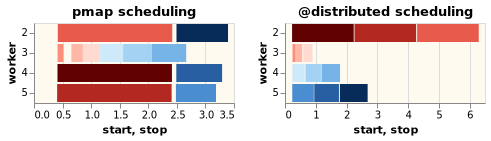

In [9]:
function plot_scheduling(t1,t2)
  colors=["#"*hex(ci) for ci in colormap("RdBu",length(tt))]
  tp1 = [(worker=t1[ii].worker,start=t1[ii].start,stop=t1[ii].stop,color= colors[ii]) for ii in 1:length(t1)]
  tp2 = [(worker=t2[ii].worker,start=t2[ii].start,stop=t2[ii].stop,color= colors[ii]) for ii in 1:length(t2)]
  @vlplot(
     columns=2,
     width=600
   )+
  [ @vlplot(
    :bar,
    data={
        values=tp1
    },
    y="worker:o",
    x="start:q",
    x2="stop:q",
    color={"color:n",scale=nothing},
    view={fill="floralwhite"},
    title="pmap scheduling"
   );
    @vlplot(
    :bar,
    data={
        values=tp2
    },
    y="worker:o",
    x="start:q",
    x2="stop:q",
    color={"color:n",scale=nothing},
    view={fill="floralwhite"},
    title="@distributed scheduling"
   )
 ]
end
plot_scheduling(t1,t2)

It is clear that `pmap` sends the first four numbers, 2, 2, 2, and 0.1, to worker A, B, C and D, repectively and then sends the next number to the next available worker. In this scenario, woker D receives the next six numbers one by one before other workers wakes up from `sleep(2)` and becomes ready to take the next unattended task. 

In comparison, the `@distributed` loop dipatches the workload in 4 partitions, the first 3 numbers are all sends to the worker A, then the next three numbers to woker B and so on. As a result, under this given input `tt`, most of the time most of the workers are idling.

Please note, workers A, B, C and D are workers 2, 3, 4 and 5, respectively, in the above example, but not necessarily in every each run. The sequence can be different every time the code runs. 

To do the timing properly, let's run the following cell. The macro `@btime` comes from `BenchmarkTools`. It runs a benchmark on the given expression and shows the minimum execution time during the benchmark.   

In [10]:
@btime t1 = pmap(x -> begin sleep(x); x end,tt);
@btime t2 = @distributed (append!) for ti in tt
                 sleep(ti)
                 [ti]
end;

  2.906 s (766 allocations: 90.00 KiB)
  6.010 s (229 allocations: 41.42 KiB)


The `pmap` execution walltime is about 7% higher than the limit 2.625 seconds. We will explain this non-negligible overhead later. 

### Length of Subtasks

Let's take a closer look into the benchmark function to understand what the minima indicate.

In [11]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 10000
BenchmarkTools.DEFAULT_PARAMETERS.evals = 3
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5
@benchmark eigen(rand(Float64,10,10))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  25.443 μs …  2.658 ms  ┊ GC (min … max): 0.00% … 98.55%
 Time  (median):     31.497 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.878 μs ± 45.032 μs  ┊ GC (mean ± σ):  2.35% ±  1.70%

       ▂▅▇▇▇█▆▃▃▁             ▁▁▁▂                             
  ▁▂▃▅▇███████████▆▅▅▅▆▄▆▆▆▇█▇███████▇█▇▆▆▆▅▅▄▄▃▃▃▃▃▂▂▂▃▂▂▂▁▂ ▄
  25.4 μs         Histogram: frequency by time        42.6 μs <

 Memory estimate: 16.16 KiB, allocs estimate: 19.

The benchmark function evaluates the expression multiple times and measures time/memory during all the evaluations. It accepts default parameters such as the number of samples, the number of evaluations per sample and the total time budget. However, it automatically decides the right configuration as it can be inconspicuous. For example, what should the number of evaluations per sample be? In the example above, `eigen(rand(10,10))` takes about 10 $\mu$s to execute which is much longer than the time resolution of a morden computer. Therefore, it decides it is sufficient to take only one sample per evaluation.

The benchmark result is stored in a `Trial` which keeps the minimum, median, mean and maximum execution time and their standard deviations, together with the corresponding memory allocation as well as the garbage collection metrics in those cases. 

We take the minimum execution time reported by `@btime` because it is a robust estimator for the execution time distribution due to the almost always positive machine noise. 

### Overhead in Dynamic Scheduling

Dynamic scheduling can mitigate the workload imbalance, but the benefit doesn't come without a cost. The time spent in the setup of the dynamic scheduler and communications between scheduler and workers are all more costly than that of the static scheduler. Potentially the data trasmission in each dispatch can be also less efficient than that in a parallel for loop.

Let's now use this `eigen(rand(10,10)` as subtasks to revisit the difference betewen the `pmap` and `@distributed` loop. Note the following comparison is slightly different than the sleep one shown above, as type assertion is added in the for loop to cope with the fact that `eigen` is not a closed operator on Float64. The eigenvalues and the elements of eigenvectors of a N$\times$N Float64 matrix can be complex.

In [12]:
@btime pmap(x -> eigen(rand(10,10)),1:12);
@btime @distributed (append!) for x in 1:12 
                 Eigen[eigen(rand(10,10))]
end;

  823.834 μs (1448 allocations: 143.56 KiB)
  433.640 μs (668 allocations: 81.56 KiB)


This time we see the @distributed for loop runs much faster and the difference becomes even greater when the total number of subtasks increases.

In [13]:
K=10^3
@btime pmap(x -> eigen(rand(10,10)),1:K);
@btime @distributed (append!) for x in 1:K
        Eigen[eigen(rand(10,10))]
end;

  59.742 ms (116323 allocations: 6.55 MiB)
  11.427 ms (17511 allocations: 2.71 MiB)


In my current environment, the threshold subtask size is about the same size of `eigen(rand(100,100))` which in general takes a few milliseconds to executes.

In [14]:
K=12
@btime pmap(x -> eigen(rand(100,100)),1:K);
@btime @distributed (append!) for x in 1:K
        Eigen[eigen(rand(100,100))]
end;

  20.270 ms (1519 allocations: 1.97 MiB)
  19.563 ms (737 allocations: 1.91 MiB)


In [15]:
@benchmark eigen(rand(100,100))

BenchmarkTools.Trial: 816 samples with 1 evaluation.
 Range (min … max):  5.630 ms …  11.573 ms  ┊ GC (min … max): 0.00% … 44.63%
 Time  (median):     6.098 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.126 ms ± 301.163 μs  ┊ GC (mean ± σ):  0.35% ±  2.55%

           ▂▂▆▃▃█▆▆▄                                           
  ▂▃▂▃▃▃▅▆▆███████████▇▆▆▅▃▄▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂ ▃
  5.63 ms         Histogram: frequency by time        7.52 ms <

 Memory estimate: 500.64 KiB, allocs estimate: 23.

To enjoy the best of both dynamic and static scheduling, `pmap` with `batch_size`>1 may be a good option to consider, but again, the trade-off depends on many factors. The distribution of the subtask execution time, the amount of data in each transfer and the amount of compute resources owned by each worker can all make a difference in the decision.

In [16]:
K=10^3
N=100
bs=floor(0.1*K/nworkers())
@show K, N, bs
@btime pmap(x -> eigen(rand(N,N)),1:K, batch_size=bs);
@btime @distributed (append!) for x in 1:K
        Eigen[eigen(rand(N,N))]
end;

(K, N, bs) = (1000, 100, 25.0)
  1.662 s (32901 allocations: 155.65 MiB)
  1.654 s (22866 allocations: 155.20 MiB)


### Things to Try

1. Change the number of workers and observe how the execution time of both `pmap` and `@distributed` for loop respond.
1. Name another few factors that may affect the total walltime of `pmap` and `@distributed` for loop differently.

## Close the Woker Pool
When finishing up the exploration, it is always a good practise to close the worker pool before quiting the notebook and shutting down the kernel.

In [17]:
## close the worker pool
t = rmprocs(workers()...)
wait(t)
println("workers are $(workers())")

workers are [1]
